# Data management with _yeoda_ (v0.3.0)

[yeoda](https://pypi.org/project/yeoda/) (**y**our **e**arth **o**bservation **d**ata **a**ccess) is a geopspatial data management library developed at the GEO Department at TU Wien for handling earth observation (EO) data. It lets you read data saved on your disk as a file (netCDF, GeoTIFF) and makes it available in datacubes. Datacubes contain standard operations, e.g., filtering, sorting, selecting, and make the data easily processable with standard Python libraries, such as _numpy_ or _xarray_.

In this notebook the general handling of _yeoda_ datacubes will be explained.


## Setting up a datacube

A _yeoda_ datacube augments existing data by integrating it into a datacube architecture similar to, e.g. [Open Data Cube](https://www.opendatacube.org/about). To set up such a datacube, _yeoda_ works in concert with [geopathfinder](https://github.com/TUW-GEO/geopathfinder) (file naming), [veranda](https://github.com/TUW-GEO/veranda) (IO classes) and [pytiletproj/Equi7Grid](https://github.com/TUW-GEO/Equi7Grid) (geo-referencing).

First, collect the files you want to put into your datacube. You can use [geopathfinder](https://github.com/TUW-GEO/geopathfinder) to conveniently gather files matching a certain file naming convention:


In [2]:
import os
from geopathfinder.folder_naming import build_smarttree

USER = os.getcwd().split('/')[2]
root_path = f'/home/{USER}/shared/datasets/fe/data/sentinel2/L2A'
folder_hierarchy = ["sub_grid", "tile_name", "var_name"]

# regex expressions are supported to select only files matching a certain pattern
# (i.e. not starting with Q ending with .tif)
tree = build_smarttree(root_path,
                       folder_hierarchy,
                       register_file_pattern="^[^Q].*.tif$")
filepaths = tree.file_register

print(f"{len(filepaths)} files registered:")
print("\n".join(filepaths[:4]))

34056 files registered:
/home/e12334178/shared/datasets/fe/data/sentinel2/L2A/EU010M/E051N016T1/b11/B11-------_SEN2COR_S2A_L2A------_20170101_20170101_EU010M_E051N016T1.tif
/home/e12334178/shared/datasets/fe/data/sentinel2/L2A/EU010M/E051N016T1/b11/B11-------_SEN2COR_S2A_L2A------_20170104_20170104_EU010M_E051N016T1.tif
/home/e12334178/shared/datasets/fe/data/sentinel2/L2A/EU010M/E051N016T1/b11/B11-------_SEN2COR_S2A_L2A------_20170111_20170111_EU010M_E051N016T1.tif
/home/e12334178/shared/datasets/fe/data/sentinel2/L2A/EU010M/E051N016T1/b11/B11-------_SEN2COR_S2A_L2A------_20170114_20170114_EU010M_E051N016T1.tif


You can use [pytiletproj/Equi7Grid](https://github.com/TUW-GEO/Equi7Grid) to define a grid to be used by the datacube.


In [3]:
from equi7grid.equi7grid import Equi7Grid

subgrid = Equi7Grid(10).EU

The file registry and grid can now be used directly as input to _yeoda's_ `EODataCube` constructor, to wrap a datacube structure around our files.


In [4]:
from geopathfinder.naming_conventions.acube_naming import ACubeFilename
from yeoda.datacube import EODataCube

dimensions = ["var_name", "dtime_1", "dtime_2", "tile_name"]
s2_cube = EODataCube(filepaths=filepaths,
                     dimensions=dimensions,
                     filename_class=ACubeFilename,
                     grid=subgrid,
                     sdim_name="tile_name",
                     tdim_name="dtime_1")
s2_cube.inventory

,filepath,var_name,dtime_1,dtime_2,tile_name
0,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-01,2017-01-01,E051N016T1
1,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-04,2017-01-04,E051N016T1
2,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-11,2017-01-11,E051N016T1
3,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-14,2017-01-14,E051N016T1
4,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-18,2017-01-18,E051N016T1
...,...,...,...,...,...
34051,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-14,2021-12-14,E050N016T1
34052,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-17,2021-12-17,E050N016T1
34053,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-21,2021-12-21,E050N016T1
34054,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-27,2021-12-27,E050N016T1


Now you're all setup and can perform operations on your freshly minted datacube. Internally, _yeoda_ uses a [GeoPandas](https://geopandas.org) dataframe to store the filename and geometry information. On top of that, datacube functions were defined to filter, split, sort, align, etc. the data. It has to be noted that most functions have a keyword argument `inplace`, same as most [GeoPandas](https://geopandas.org) functions. In the next sections some example usages of these functions will be shown.

This example showcases the most generic flavour of a datacube, however there are also more specialized data cube classes available, which are tailored towards the products operated by the research group Remote Sensing of the GEO Department at TU Wien (TUWGEO). See the next section.


### Setting up product specific datacubes

To work with preprocessed data you can use the classes `SIG0DataCube` for sigma nought and `GMRDataCube` for radiometric terrain-flattened gamma nought data. On the value-added data side, `SSMDataCube` allows you to access the TUWGEO SSM data, and `SCATSARSWIDataCube` SWI data, respectively.


In [5]:
from geopathfinder.naming_conventions.sgrt_naming import SgrtFilename
from yeoda.products.base import ProductDataCube

root_path = f"/home/{USER}/shared/datasets/fe/data/sentinel1/preprocessed/EU010M"
folder_hierarchy = ["tile_name", "var_name"]

tree = build_smarttree(root_path,
                       folder_hierarchy,
                       register_file_pattern="^[^Q].*.tif$")
dimensions = ["time", "var_name", "tile_name", "pol"]
scale_factor = 100  # with yeoda v0.3.0, the scale factor still needs to be defined by the user
sig0_cube = ProductDataCube(filepaths=tree.file_register,
                            dimensions=dimensions,
                            filename_class=SgrtFilename,
                            grid=Equi7Grid(10).EU,
                            scale_factor=scale_factor)
sig0_cube.inventory

,filepath,time,var_name,tile_name,pol
0,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E051N016T1,VH
1,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E051N016T1,VV
2,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 16:58:55,SIG0,E051N016T1,VH
3,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 16:58:55,SIG0,E051N016T1,VV
4,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-02 16:50:01,SIG0,E051N016T1,VH
...,...,...,...,...,...
18359,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-27 05:26:33,SIG0,E050N016T1,VV
18360,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-29 05:10:37,SIG0,E050N016T1,VH
18361,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-29 05:10:37,SIG0,E050N016T1,VV
18362,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:46,SIG0,E050N016T1,VH


Note, that _yeoda_ is not limited to GeoTIFF files, it also supports NetCDF files.


## Dimension operations

The following sections shows how you can manipulate the dimensions of the datacube itself, before doing any further operations based on them.


### Renaming dimensions

If you have to work with a pre-defined naming convention in _geopathfinder_ (e.g. the _yeoda_ naming convention) and if you do not agree with the naming of the filename parts/dimensions, you can still rename dimensions afterwards:


In [6]:
sig0_cube.rename_dimensions({'tile_name': 'tile'}, inplace=True)
sig0_cube.inventory

,filepath,time,var_name,tile,pol
0,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E051N016T1,VH
1,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E051N016T1,VV
2,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 16:58:55,SIG0,E051N016T1,VH
3,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 16:58:55,SIG0,E051N016T1,VV
4,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-02 16:50:01,SIG0,E051N016T1,VH
...,...,...,...,...,...
18359,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-27 05:26:33,SIG0,E050N016T1,VV
18360,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-29 05:10:37,SIG0,E050N016T1,VH
18361,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-29 05:10:37,SIG0,E050N016T1,VV
18362,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:46,SIG0,E050N016T1,VH


### Adding dimensions

You can simply add new filepath-dependent values (e.g. file size, cloud coverage, …) along a new dimension (e.g. named “new_dimension”) with a few lines of code:


In [7]:
extended = sig0_cube.add_dimension("ones", [1] * len(sig0_cube))
extended.inventory

,filepath,time,var_name,tile,pol,ones
0,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E051N016T1,VH,1
1,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E051N016T1,VV,1
2,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 16:58:55,SIG0,E051N016T1,VH,1
3,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 16:58:55,SIG0,E051N016T1,VV,1
4,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-02 16:50:01,SIG0,E051N016T1,VH,1
...,...,...,...,...,...,...
18359,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-27 05:26:33,SIG0,E050N016T1,VV,1
18360,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-29 05:10:37,SIG0,E050N016T1,VH,1
18361,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-29 05:10:37,SIG0,E050N016T1,VV,1
18362,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:46,SIG0,E050N016T1,VH,1


## Sorting

One of the most common operations is to sort the inventory according to some metadata, e.g. the timestamp:


In [8]:
sorted_descending = sig0_cube.sort_by_dimension('time', ascending=False)
sorted_descending.inventory

,filepath,time,var_name,tile,pol
18363,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:46,SIG0,E050N016T1,VV
18362,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:46,SIG0,E050N016T1,VH
3550,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:46,SIG0,E051N016T1,VH
3551,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:46,SIG0,E051N016T1,VV
7108,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:21,SIG0,E051N015T1,VH
...,...,...,...,...,...
3553,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:01:20,SIG0,E051N015T1,VV
13027,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E052N016T1,VV
13026,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E052N016T1,VH
1,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E051N016T1,VV


## Filtering

Once you have your datacube structure setup you can also filter it before doing any processing. For instance, if you want to do some runtime intensive processing on only a small portion of the data. The following sections give a few examples of the available filtering methods. Again most methods provide a `inplace` flag, similar to [GeoPandas](https://geopandas.org).


### Filter by geometry

You can filter for arbitrary geometry or a list of bounding box coordinates. The filtered cube will only contain files within the specified geometry.


In [9]:
import osr

sref = osr.SpatialReference()
sref.ImportFromEPSG(4326)  # LonLat spatial reference system

bbox_inside = [(12.628, 46.385),
               (15.768, 48.431)]  # [(x_min, y_min), (x_max, y_max)]
filtered_by_bbox = sig0_cube.filter_spatially_by_geom(bbox_inside, sref=sref)
print(
    f"Number of filtered files with a bbox located inside the data tiles: {len(filtered_by_bbox)}"
)

bbox_outside = [(4.404, 44.443), (8.826, 47.811)]
filtered_by_bbox = sig0_cube.filter_spatially_by_geom(bbox_outside, sref=sref)
print(
    f"Number of filtered files with a bbox located outside the data tiles: {len(filtered_by_bbox)}"
)

Number of filtered files with a bbox located inside the data tiles: 14834
Number of filtered files with a bbox located outside the data tiles: 0


### Filter by dimension

A very important function is `filter_by_dimension`, which accepts a list of values and expressions to filter the data along a dimension. The list of `expressions` has the same length as the values list and includes mathematical comparison operators, e.g. `“==”`, `“<=”`, `“>=”`, `“<”`, `“>”` (`“==”` is default). Some examples are:


In [10]:
# only consider VV polarisation
only_vv = sig0_cube.filter_by_dimension(['VV'], name="pol")
only_vv.inventory

,filepath,time,var_name,tile,pol
0,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:46,SIG0,E050N016T1,VV
1,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:46,SIG0,E051N016T1,VV
2,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:21,SIG0,E048N015T1,VV
3,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-30 16:59:21,SIG0,E051N015T1,VV
4,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-29 05:10:37,SIG0,E051N015T1,VV
...,...,...,...,...,...
9152,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 16:58:55,SIG0,E051N015T1,VV
9153,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:01:20,SIG0,E052N015T1,VV
9154,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:01:20,SIG0,E051N015T1,VV
9155,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E052N016T1,VV


In [11]:
from datetime import datetime

# only consider data between 2019-02-01 and 2019-03-01
time_span = [(datetime(2019, 2, 1), datetime(2019, 3, 1))]
time_span_only = sig0_cube.filter_by_dimension(time_span, [('>=', '<')],
                                               name='time')
time_span_only.inventory

,filepath,time,var_name,tile,pol
0,/home/e12334178/shared/datasets/fe/data/sentin...,2019-02-28 16:42:06,SIG0,E052N016T1,VV
1,/home/e12334178/shared/datasets/fe/data/sentin...,2019-02-28 16:42:06,SIG0,E052N016T1,VH
2,/home/e12334178/shared/datasets/fe/data/sentin...,2019-02-28 16:42:06,SIG0,E051N015T1,VH
3,/home/e12334178/shared/datasets/fe/data/sentin...,2019-02-28 16:42:06,SIG0,E051N015T1,VV
4,/home/e12334178/shared/datasets/fe/data/sentin...,2019-02-28 16:42:06,SIG0,E051N016T1,VH
...,...,...,...,...,...
279,/home/e12334178/shared/datasets/fe/data/sentin...,2019-02-01 05:09:18,SIG0,E052N016T1,VV
280,/home/e12334178/shared/datasets/fe/data/sentin...,2019-02-01 05:09:18,SIG0,E051N016T1,VH
281,/home/e12334178/shared/datasets/fe/data/sentin...,2019-02-01 05:09:18,SIG0,E051N016T1,VV
282,/home/e12334178/shared/datasets/fe/data/sentin...,2019-02-01 05:09:18,SIG0,E050N016T1,VV


### Filter by file pattern

You can also directly filter on the filename using a regex pattern:


In [12]:
filtered_by_pattern = sig0_cube.filter_files_with_pattern(".*_066_.*")
filtered_by_pattern.inventory

,filepath,time,var_name,tile,pol
13010,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-20 05:35:11,SIG0,E048N015T1,VH
13011,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-20 05:35:11,SIG0,E048N015T1,VV
12999,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-14 05:34:39,SIG0,E048N015T1,VV
12998,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-14 05:34:39,SIG0,E048N015T1,VH
12986,/home/e12334178/shared/datasets/fe/data/sentin...,2021-12-08 05:35:12,SIG0,E048N015T1,VH
...,...,...,...,...,...
9523,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-27 05:34:33,SIG0,E048N015T1,VV
9512,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-15 05:34:33,SIG0,E048N015T1,VH
9513,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-15 05:34:33,SIG0,E048N015T1,VV
9499,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-03 05:34:33,SIG0,E048N015T1,VV


## Splitting

You can use split operations to segregate your datacube into chunks, which can then be used for processing. For instance, you could split data into months and calculate monthly means.


### Split by dimension

Split a datacube based on dimension values. The splitting conditions are expressed the same way as in `filter_by_dimension`.


In [13]:
values = ['VV', 'VH']
vv_cube, vh_cube = sig0_cube.split_by_dimension(values, name="pol")
print(
    f"Parent datacube of length {len(sig0_cube)}, split into two datacubes of length {len(vv_cube)} and {len(vh_cube)}."
)

Parent datacube of length 18364, split into two datacubes of length 9157 and 9157.


### Split monthly

If you want to analyse your data under certain temporal aspects, in this case in a monthly manner, you can split up the original data cube into smaller monthly data cubes (if the data covers more than a month):


In [14]:
months = sig0_cube.split_monthly()
print(f"Parent datacube has been split into {len(months)} monthly datacubes.")

Parent datacube has been split into 60 monthly datacubes.


Note, that _yeoda_ also provides convenience functions for yearly splits.


## Joining

If you have multiple datacubes, or have split them up to perform some processing, you can concatenate them using join operations. The following section will look closer at a few of them.


### Intersection

You can use this operation to get only those fields of multiple datacubes with matching dimensions or with a specific matching dimension:


In [15]:
only_jan_remains = sig0_cube.intersect(months[0], on_dimension='time')
only_jan_remains.inventory

,filepath,time,var_name,tile,pol
0,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E052N015T1,VH
1,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E052N016T1,VH
2,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E052N015T1,VV
3,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E051N016T1,VH
4,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E051N015T1,VH
...,...,...,...,...,...
253,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:01:20,SIG0,E051N015T1,VV
254,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E052N016T1,VV
255,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E052N016T1,VH
256,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-01 05:00:55,SIG0,E051N016T1,VV


### Union

If you have two data cubes and you want to unite their information, you can simply do:


In [16]:
jan_and_feb = months[0].unite(months[1])
jan_and_feb.inventory

,filepath,time,var_name,tile,pol
0,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E052N015T1,VH
1,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E052N016T1,VH
2,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E052N015T1,VV
3,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E051N016T1,VH
4,/home/e12334178/shared/datasets/fe/data/sentin...,2017-01-31 05:01:51,SIG0,E051N015T1,VH
...,...,...,...,...,...
487,/home/e12334178/shared/datasets/fe/data/sentin...,2017-02-01 16:50:58,SIG0,E051N016T1,VH
488,/home/e12334178/shared/datasets/fe/data/sentin...,2017-02-01 16:50:33,SIG0,E051N015T1,VV
489,/home/e12334178/shared/datasets/fe/data/sentin...,2017-02-01 16:50:33,SIG0,E052N015T1,VV
490,/home/e12334178/shared/datasets/fe/data/sentin...,2017-02-01 16:50:33,SIG0,E052N015T1,VH


### Alignment

The `align_dimension` method aligns a datacube with respect to a second datacube along a dimension (`name`). In other words, the order and the length of the dimension will then be the same. This also means that datacube entries are duplicated if they appear more often in the second datacube.


In [17]:
# create a small test datacube
small = sig0_cube.filter_by_dimension(datetime(2015, 2, 1, 4, 47, 30),
                                      name='time')
print(f"Small datacube of length {len(small)}")
# align the 'band' dimension with the large datacube
aligned_with_duplicates = small.align_dimension(sig0_cube, 'pol')
aligned_with_duplicates.inventory

Small datacube of length 0
No common dimension values found. Original data cube is returned.


,filepath,time,var_name,tile,pol


## Loading Data

This section demonstrates how to load data. All functions have a common set of keyword arguments, where the most important ones are discussed here:

-   `band`: This argument specifies the band name as a string.
-   `dtype`: There are many types of _Python_ data structures to store array-like data, and their selection mainly depends on what you want to do with the loaded data later on. These are offered by _yeoda_:
    -   xarray.DataSet (“xarray”)
    -   numpy.ndarray (“numpy”)
    -   pandas.DataFrame (“dataframe”)
-   `origin`: Depending on the chosen return data type, this parameter defines the origin of the pixel coordinates in the world system. The origin can be one of the following:
    -   upper right (“ur”, default)
    -   upper left (“ul”)
    -   lower right (“lr”)
    -   lower left (“ll”)
    -   center ("c")


### Load by geometry

You can load data for a region defined by an arbitrary geometry, similar to how you can filter by a geometry. Geometries do not need to be axis-parallel, but data for the spanning axis aligned bounding box will be loaded nonetheless, to fit into an array data-structure. However, it is possible to mask any data outside the specified geometry by setting the `apply_mask` parameter to true.


In [18]:
import matplotlib.pyplot as plt
import numpy as np

import sys

USER = os.getcwd().split('/')[2]
sys.path.append(
    f'/home/{USER}/shared/120.030-2023W/groups/PracticalExGr_3/src/MWRSExCode')
from testarea import TestArea, coords_from_google_maps

polygon = [(10.6419, 46.7977), (10.4689, 47.2261), (11.3516, 47.3510),
           (11.3689, 46.9161), (10.9426, 46.9979)]

polygon = coords_from_google_maps([(48.365325929665225, 16.491747734015267),
                                   (48.45160471550519, 16.491747734015267),
                                   (48.45160471550519, 16.63199879296561),
                                   (48.365325929665225, 16.63199879296561),
                                   (48.365325929665225, 16.491747734015267)])

months = sig0_cube.split_monthly()
jan_vv = months[0].filter_spatially_by_geom(polygon, sref=sref)\
                  .filter_by_dimension(['VV'], name="pol")
# jan_vv = sig0_cube.filter_spatially_by_geom(polygon, sref=sref)\
#                   .filter_by_dimension(['VV'], name="pol")
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # masked_xarray = jan_vv.load_by_geom(polygon,
    #                                     sref=sref,
    #                                     apply_mask=False,
    #                                     dtype="numpy")

    masked_xarray = jan_vv.load_by_geom(polygon,
                                        sref=sref,
                                        apply_mask=False,
                                        dtype="xarray")
    masked_xarray = masked_xarray.rename({'1': 'data'})

# plt.figure(figsize=(15, 5))
# plt.imshow(10 * np.log10(np.nanmean(10**(masked_xarray / 10), axis=0)),
#            cmap=plt.cm.Greys_r)

In [19]:
masked_xarray

<xarray.Dataset>
Dimensions:  (time: 20, y: 1062, x: 1131)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-31T05:01:51 ... 2017-01-01T05:00:55
  * y        (y) float64 1.644e+06 1.644e+06 1.644e+06 ... 1.633e+06 1.633e+06
  * x        (x) float64 5.281e+06 5.281e+06 5.281e+06 ... 5.293e+06 5.293e+06
Data variables:
    data     (time, y, x) float64 -14.28 -13.72 -15.41 ... -11.94 -15.84 -17.53

In [ ]:
masked_xarray.data[0][0]

<xarray.DataArray 'data' (x: 1131)>
array([-14.28, -13.72, -15.41, ...,  -7.07,  -8.63,  -9.83])
Coordinates:
    time     datetime64[ns] 2017-01-31T05:01:51
    y        float64 1.644e+06
  * x        (x) float64 5.281e+06 5.281e+06 5.281e+06 ... 5.293e+06 5.293e+06

In [ ]:
masked_xarray.data[0][0][0]

<xarray.DataArray 'data' ()>
array(-14.28)
Coordinates:
    time     datetime64[ns] 2017-01-31T05:01:51
    y        float64 1.644e+06
    x        float64 5.281e+06

In [22]:
from curses import BUTTON1_TRIPLE_CLICKED
import numpy as np
from tqdm import trange
# Assuming 'masked_xarray' is a NumPy array with shape (time: 20, y: 1062, x: 1131)

_dict = {}
# Create an empty list to store time series data
time_series = []

# Loop through x and y dimensions to extract time series for each

for y in trange(len(masked_xarray.y)):
    # print(y)
    for x in range(len(masked_xarray.x)):
        # print(x)
        for t in range(len(masked_xarray.time)):
            # print(t)

            # t, y, x = t.values, y.values, x.values
            # print(t, y, x)
            # Extract time series for the current x, y pair
            data = float(masked_xarray.data[t, y, x].values)
            key = (float(masked_xarray.x[x].values),
                   float(masked_xarray.y[y].values))
            if key not in _dict:
                _dict[key] = [data]
            else:
                _dict[key].append(data)

# 'time_series' is a list containing time series for each x, y pair in 'masked_xarray'
_dict

  0%|          | 0/1062 [00:00<?, ?it/s]

  0%|          | 4/1062 [00:50<3:42:23, 12.61s/it]


KeyboardInterrupt: 

In [29]:
len(masked_xarray.data.values.flatten())

24022440

In [31]:
masked_xarray.data.values.flatten()[np.isfinite(
    masked_xarray.data.values.flatten())]

23964853

In [43]:
import numpy as np
from tqdm import trange
from scipy import stats

flattend_finite = masked_xarray.data.values.flatten()[np.isfinite(
    masked_xarray.data.values.flatten())]
# Desired confidence level
confidence_level = 0.95  # For a 95% confidence level

# Calculate Z-score for the desired confidence level
z_score = stats.norm.ppf((1 + confidence_level) / 2)

# Calculate margin of error with a specific confidence level
margin_of_error = z_score * np.std(flattend_finite) / np.sqrt(
    len((flattend_finite)))


def no_samlpes(z_score, e, p=0.5):
    return int((z_score**2 * p * (1 - p)) / e**2)


samples = no_samlpes(z_score, margin_of_error)
print(
    f"Number of samples needed for a confidence level of {confidence_level}: {samples}"
)


Number of samples needed for a confidence level of 0.95: 581684


In [44]:
import xarray as xr
import pandas as pd

# Initialize an empty DataFrame
df = pd.DataFrame()

# Open a Parquet file writer
filename = 'data_out.parquet'
parquet_writer = pd.ParquetWriter(filename, mode='w')

# Loop through x and y dimensions to extract time series for each
for y in trange(len(masked_xarray.y)):
    for x in range(len(masked_xarray.x)):
        # Initialize a list to store data for each x, y pair
        data_list = []

        for t in range(len(masked_xarray.time)):
            data = float(masked_xarray.data[t, y, x].values)
            data_list.append(data)

        # Create a key for the current x, y pair
        key = (float(masked_xarray.x[x].values),
               float(masked_xarray.y[y].values))

        # Add data for the current x, y pair to the DataFrame
        df[key] = data_list

    # Write DataFrame to Parquet file after each y iteration
    parquet_writer.write(df)

    # Clear DataFrame to free up memory for the next iteration
    df = pd.DataFrame()

# Close the Parquet file writer
parquet_writer.close()


AttributeError: module 'pandas' has no attribute 'ParquetWriter'

In [47]:
import xarray as xr
import pandas as pd

samples = 10
no_sample = 0


def get_random_coord_pair():
    rand_x, rand_y = np.random.randint(0, len(
        masked_xarray.x)), np.random.randint(0, len(masked_xarray.y))
    # return float(masked_xarray.x.values[rand_x]), float(masked_xarray.y.values[rand_y])
    return rand_x, rand_y


with open('data_out.json', 'w') as f:
    f.write('{\n')
    coords_used = []
    while no_sample < samples:
        rand_coords = get_random_coord_pair()
        while rand_coords in coords_used:
            rand_coords = get_random_coord_pair()

        data_list = []
        for t in range(len(masked_xarray.time)):
            data = float(masked_xarray.data[t, rand_coords[1],
                                            rand_coords[0]].values)
            data_list.append(data)

        # Create a key for the current x, y pair
        key = (float(masked_xarray.x[rand_coords[0]].values),
               float(masked_xarray.y[rand_coords[1]].values))

        f.write(f'{key}: {data_list},\n')

        no_sample += 1
        coords_used.append(rand_coords)

    f.write('}')


In [49]:
import xarray as xr
import numpy as np

samples = 10
no_sample = 0


def get_random_coord_pair():
    rand_x, rand_y = np.random.randint(0, len(
        masked_xarray.x)), np.random.randint(0, len(masked_xarray.y))
    return rand_x, rand_y


# Create an empty dataset
combined_dataset = xr.Dataset()

while no_sample < samples:
    rand_coords = get_random_coord_pair()
    data_list = []

    for t in range(len(masked_xarray.time)):
        data = float(masked_xarray.data[t, rand_coords[1],
                                        rand_coords[0]].values)
        data_list.append(data)

    key = (float(masked_xarray.x[rand_coords[0]].values),
           float(masked_xarray.y[rand_coords[1]].values))

    # Create a DataArray for the current x, y pair
    data_array = xr.DataArray(data_list,
                              dims='time',
                              coords={'time': masked_xarray.time})

    # Create a dataset for the current iteration
    dataset = xr.Dataset(data_vars={'data': data_array})
    dataset['data'].attrs['lat'] = key[0]
    dataset['data'].attrs['lon'] = key[1]

    # Append the dataset for this iteration to the combined dataset
    combined_dataset = xr.concat([combined_dataset, dataset], dim='sample')

    no_sample += 1

# Write the combined dataset to a NetCDF file
# combined_dataset.to_netcdf('output.nc')
combined_dataset


<xarray.Dataset>
Dimensions:  (sample: 10, time: 20)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-31T05:01:51 ... 2017-01-01T05:00:55
Dimensions without coordinates: sample
Data variables:
    data     (sample, time) float64 -14.47 -12.92 -13.58 ... -13.99 -13.42

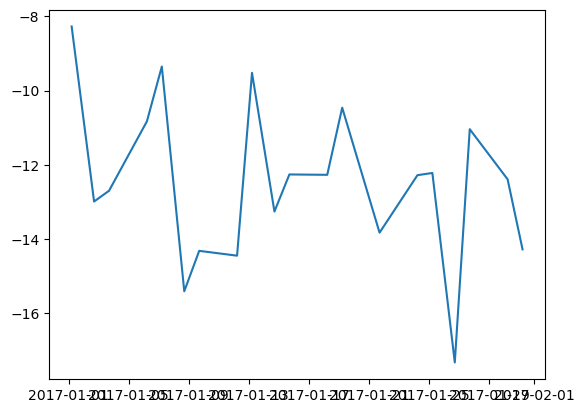

In [ ]:
masked_xarray.data[0].values

plt.figure()
plt.plot(masked_xarray.time, _dict[(0, 0)])

### Load by coordinates

The `load_by_coords`, accepts a list of X and a list of Y (world system) coordinates as input. If the spatial reference of the coordinates is not equal to the data, you need to specify the spatial reference keyword argument `sref`.


In [ ]:
import ogr

# defining a point to sample a time series from
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(16.210, 47.242)
point.AssignSpatialReference(sref)

# load data by coordinates
point_data = sig0_cube.filter_by_dimension(['VV'], name='pol')
point_data.filter_spatially_by_geom(point, sref=sref, inplace=True)
time_series = point_data.load_by_coords(point.GetX(),
                                        point.GetY(),
                                        band=1,
                                        sref=sref,
                                        dtype='numpy')

# prepare data for graph
x_vals = point_data["time"].values
y_vals = time_series.flatten()
mask = np.isfinite(y_vals)  # only use valid values

# create a nice plot
plt.figure(figsize=(15, 5))
plt.title('Backscatter timeseries')
plt.plot(x_vals[mask], y_vals[mask], alpha=0.5)
plt.scatter(x_vals[mask],
            y_vals[mask],
            s=15,
            color="red",
            label="measurements")
plt.xlabel('Date')
plt.ylabel('dB')
plt.grid()
plt.legend()
plt.show()

NameError: name 'sref' is not defined

By specifying the `dtype` to be `"numpy"` parameter of the loading function, we request a plain _NumPy_ array instead of the default _xarray_.


### Load by pixels

`load_by_pixels` expects pixel coordinates given by a list of row and column indexes. The keyword arguments `row_size` and `col_size` allow you to define a window, where the specified ranges count from left to right (columns) and from top to bottom (rows) starting at the given row and column coordinates.


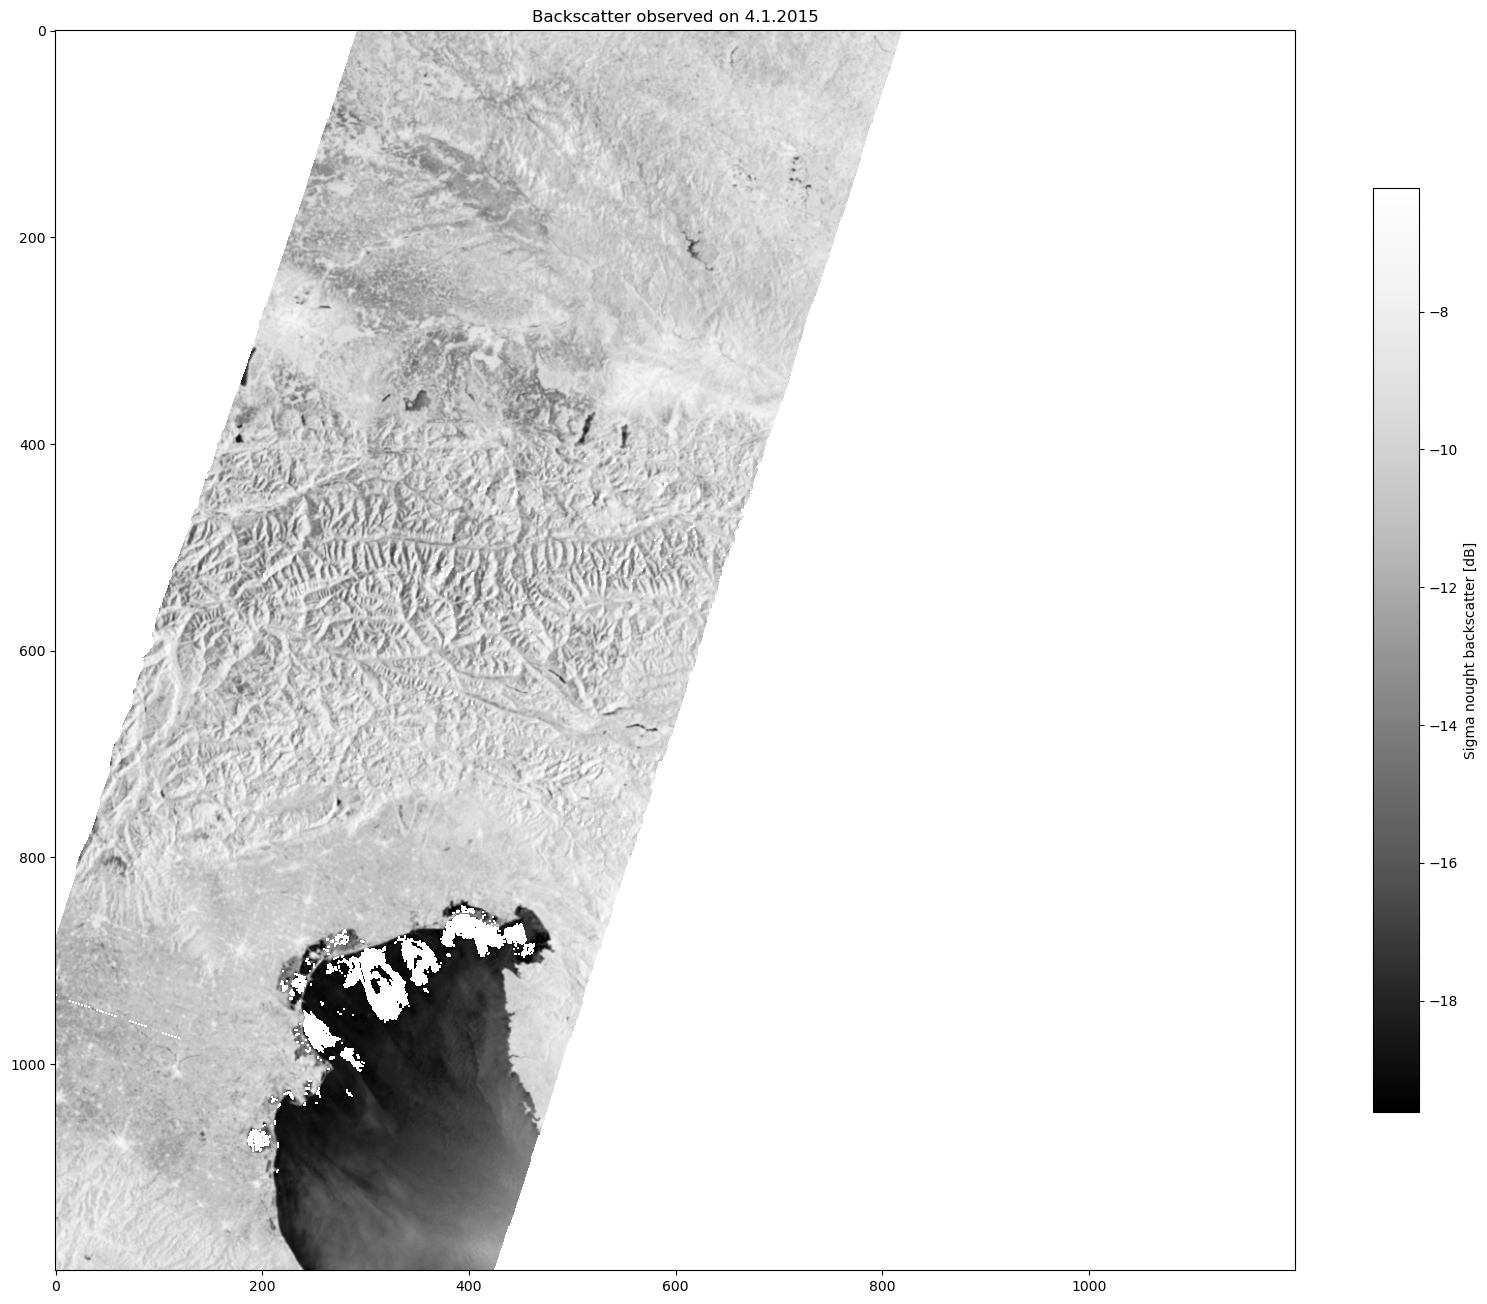

In [ ]:
# filter data cube for one day
single_day = sig0_cube.filter_spatially_by_geom(point, sref=sref)\
                      .filter_by_dimension(datetime(2015, 1, 4, 5, 17, 16), name='time')

pixels = single_day.load_by_pixels(0,
                                   0,
                                   row_size=1200,
                                   col_size=1200,
                                   dtype="numpy")

# plot the data
plt.figure(figsize=(20, 20))
plt.title('Backscatter observed on 4.1.2015')
img_h = plt.imshow(pixels[0, ...], cmap=plt.get_cmap("Greys_r"))
cb = plt.colorbar(img_h, shrink=0.6)
cb.set_label("Sigma nought backscatter [dB]")
plt.show()